# Analysis of LSOA results: change in mRS less than three

In [1]:
file_name = 'lsoa_base'
limit_to_england = False

data_field = 'added_mrs<=2'
data_name = 'added mRS <= 2'

## Proportions of stroke types: Analysis of SAMueL data

Data from SAMueL using NIHSS 11+ as a surrogate for LVO:

| Admission type                       | All arrivals | Arrival within 6 hrs known onset | Arrival within 4 hrs known onset |
|--------------------------------------|--------------|----------------------------------|----------------------------------|
| Proportion all admissions            | 100          | 42.9                             | 37.1                             |
| Proportion haemorrhagic              | 11.5         | 13.6                             | 14.1                             |
| Proportion ischaemic                 | 88.5         | 86.4                             | 85.9                             |
| Proportion ischaemic with NIHSS 0-10 | 74.9         | 67.4                             | 65.7                             |
| Proportion ischaemic with NIHSS 11+  | 25.1         | 32.6                             | 34.3                             |

For original analysis see: https://samuel-book.github.io/samuel-1/descriptive_stats/10_using_nihss_10_for_lvo.html

## Import packages

In [2]:
import contextily as ctx
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

pd.set_option('display.max_rows', 150)

## Load data

### Load shape file

In [3]:
filename = "zip://./data/Lower_layer_super_output_areas_(E+W)_2011_Boundaries_(Generalised_Clipped)_V2.zip"
lsoa_gdf = geopandas.read_file(filename, crs='EPSG:27700')
lsoa_gdf.head()

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry
0,E01000001,City of London 001A,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [4]:
# Load country outline
outline = geopandas.read_file('./data/Countries_(December_2022)_GB_BFC.zip')
if limit_to_england:
    mask = outline['CTRY22NM'] == 'England'
    outline = outline[mask]
else:
    mask = (outline['CTRY22NM'] == 'England') | (outline['CTRY22NM'] == 'Wales')
    outline = outline[mask]

In [5]:
outline

,FID,CTRY22CD,CTRY22NM,CTRY22NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,1,E92000001,England,Lloegr,394883,370883,-2.07811,53.23497,{096C3540-B006-4D2D-BCDF-B3E945B80D51},1.358939e+07,1.304623e+11,"MULTIPOLYGON (((83962.840 5401.150, 83970.680 ..."
2,3,W92000004,Wales,Cymru,263405,242881,-3.99417,52.06741,{1DFA050A-C94B-4E58-8210-DE8274C7C33E},3.273688e+06,2.078260e+10,"MULTIPOLYGON (((322081.699 165165.901, 322082...."


### Load hospital info

In [6]:
hospitals_gdf = geopandas.read_file('./data/stroke_hospitals_2022.csv')
hospitals_gdf.geometry = geopandas.points_from_xy(
        hospitals_gdf.Easting, hospitals_gdf.Northing)
# Set crs for geometry, using epsg4326 for lat/long
hospitals_gdf = hospitals_gdf.set_crs(epsg=27700)

if limit_to_england:
    mask = hospitals_gdf['Country'] ==  'England'
    hospitals_gdf = hospitals_gdf[mask]
hospitals_gdf.head()


,Postcode,Hospital_name,Use_IVT,Use_MT,Use_MSU,Country,Strategic Clinical Network,Health Board / Trust,Stroke Team,SSNAP name,...,ivt_rate,Easting,Northing,long,lat,Neuroscience,30 England Thrombectomy Example,hospital_city,Notes,geometry
0,RM70AG,RM70AG,1,1,1,England,London SCN,Barking,Havering and Redbridge University Hospitals N...,Queens Hospital Romford HASU,...,11.9,551118,187780,0.179030640661934,51.5686465521504,1,0,Romford,,POINT (551118.000 187780.000)
1,E11BB,E11BB,1,1,1,England,London SCN,Barts Health NHS Trust,The Royal London Hospital,Royal London Hospital HASU,...,13.4,534829,181798,-0.0581329916047372,51.5190178361295,1,1,Royal London,,POINT (534829.000 181798.000)
2,SW66SX,SW66SX,1,1,1,England,London SCN,Imperial College Healthcare NHS Trust,"Charing Cross Hospital, London",Charing Cross Hospital HASU,...,9.9,524226,176487,-0.212736111308184,51.4737165811988,1,1,Charing Cross,,POINT (524226.000 176487.000)
3,SE59RW,SE59RW,1,1,1,England,London SCN,King's College Hospital NHS Foundation Trust,"King's College Hospital, London",King's College Hospital HASU,...,15,532536,176228,-0.0932514945350423,51.4695052907757,1,0,Kings College,,POINT (532536.000 176228.000)
4,BR68ND,BR68ND,1,0,0,England,London SCN,King's College Hospital NHS Foundation Trust,Princess Royal University Hospital,Princess Royal University Hospital HASU,...,13.3,543443,165032,0.0591464390000555,51.3662434074157,0,0,Princess Royal,,POINT (543443.000 165032.000)


### Load LSOA model output data

In [7]:
lsoa_data = pd.read_csv(f'./output/{file_name}.csv')
lsoa_data.head(3).T

,0,1,2
lsoa,Adur 001A,Adur 001B,Adur 001C
closest_ivt_unit,BN25BE,BN25BE,BN112DH
closest_ivt_time,17.6,18.7,17.6
closest_mt_unit,BN25BE,BN25BE,BN25BE
closest_mt_time,17.6,18.7,19.8
transfer_mt_unit,BN25BE,BN25BE,BN25BE
transfer_mt_time,0.0,0.0,31.6
mt_transfer_required,False,False,True
msu_unit,BN25BE,BN25BE,BN25BE
msu_time,17.6,18.7,19.8


In [8]:
# Merge with shape file

lsoa_data_gdf = lsoa_gdf.merge(lsoa_data, left_on='LSOA11NM', right_on='lsoa', how='right')
lsoa_data_gdf.head()

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry,lsoa,closest_ivt_unit,closest_ivt_time,closest_mt_unit,closest_mt_time,transfer_mt_unit,...,mothership_nlvo_ivt_added_mrs<=2,mothership_lvo_ivt_added_mrs<=2,mothership_lvo_mt_added_mrs<=2,weighted_drip_ship_added_utility,weighted_mothership_added_utility,weighted_drip_ship_added_mrs<=2,weighted_mothership_added_mrs<=2,weighted_drip_ship_mean_shift,weighted_mothership_mean_shift,LSOA_predicted_admissions
0,E01031349,Adur 001A,Adur 001A,"POLYGON ((525328.061 105725.349, 525436.843 10...",Adur 001A,BN25BE,17.6,BN25BE,17.6,BN25BE,...,0.11,0.04,0.17,0.031414,0.031414,0.03305,0.03305,-0.16430,-0.16430,2.550427
1,E01031350,Adur 001B,Adur 001B,"POLYGON ((524713.079 106781.551, 524753.189 10...",Adur 001B,BN25BE,18.7,BN25BE,18.7,BN25BE,...,0.11,0.04,0.17,0.031311,0.031311,0.03305,0.03305,-0.16315,-0.16315,2.550427
2,E01031351,Adur 001C,Adur 001C,"POLYGON ((523976.094 108414.594, 524038.094 10...",Adur 001C,BN112DH,17.6,BN25BE,19.8,BN25BE,...,0.11,0.04,0.17,0.025895,0.031311,0.02705,0.03305,-0.13430,-0.16315,2.550427
3,E01031352,Adur 001D,Adur 001D,"POLYGON ((524263.733 106628.407, 524317.000 10...",Adur 001D,BN112DH,17.6,BN25BE,19.8,BN25BE,...,0.11,0.04,0.17,0.025895,0.031311,0.02705,0.03305,-0.13430,-0.16315,2.550427
4,E01031370,Adur 001E,Adur 001E,"POLYGON ((522978.319 106148.604, 523260.859 10...",Adur 001E,BN112DH,16.5,BN25BE,19.8,BN25BE,...,0.11,0.04,0.17,0.026245,0.031311,0.02705,0.03305,-0.13530,-0.16315,2.550427


## Calculate difference between Mothership and Drip and Ship

In [9]:
lsoa_data_gdf[f'nlvo_ivt_{data_field}_mothership_minus_dripship'] = \
    lsoa_data_gdf[f'mothership_nlvo_ivt_{data_field}'] - lsoa_data_gdf[f'drip_ship_nlvo_ivt_{data_field}']

lsoa_data_gdf[f'lvo_mt_{data_field}_mothership_minus_dripship'] = \
    lsoa_data_gdf[f'mothership_lvo_mt_{data_field}'] - lsoa_data_gdf[f'drip_ship_lvo_mt_{data_field}']

## Plots

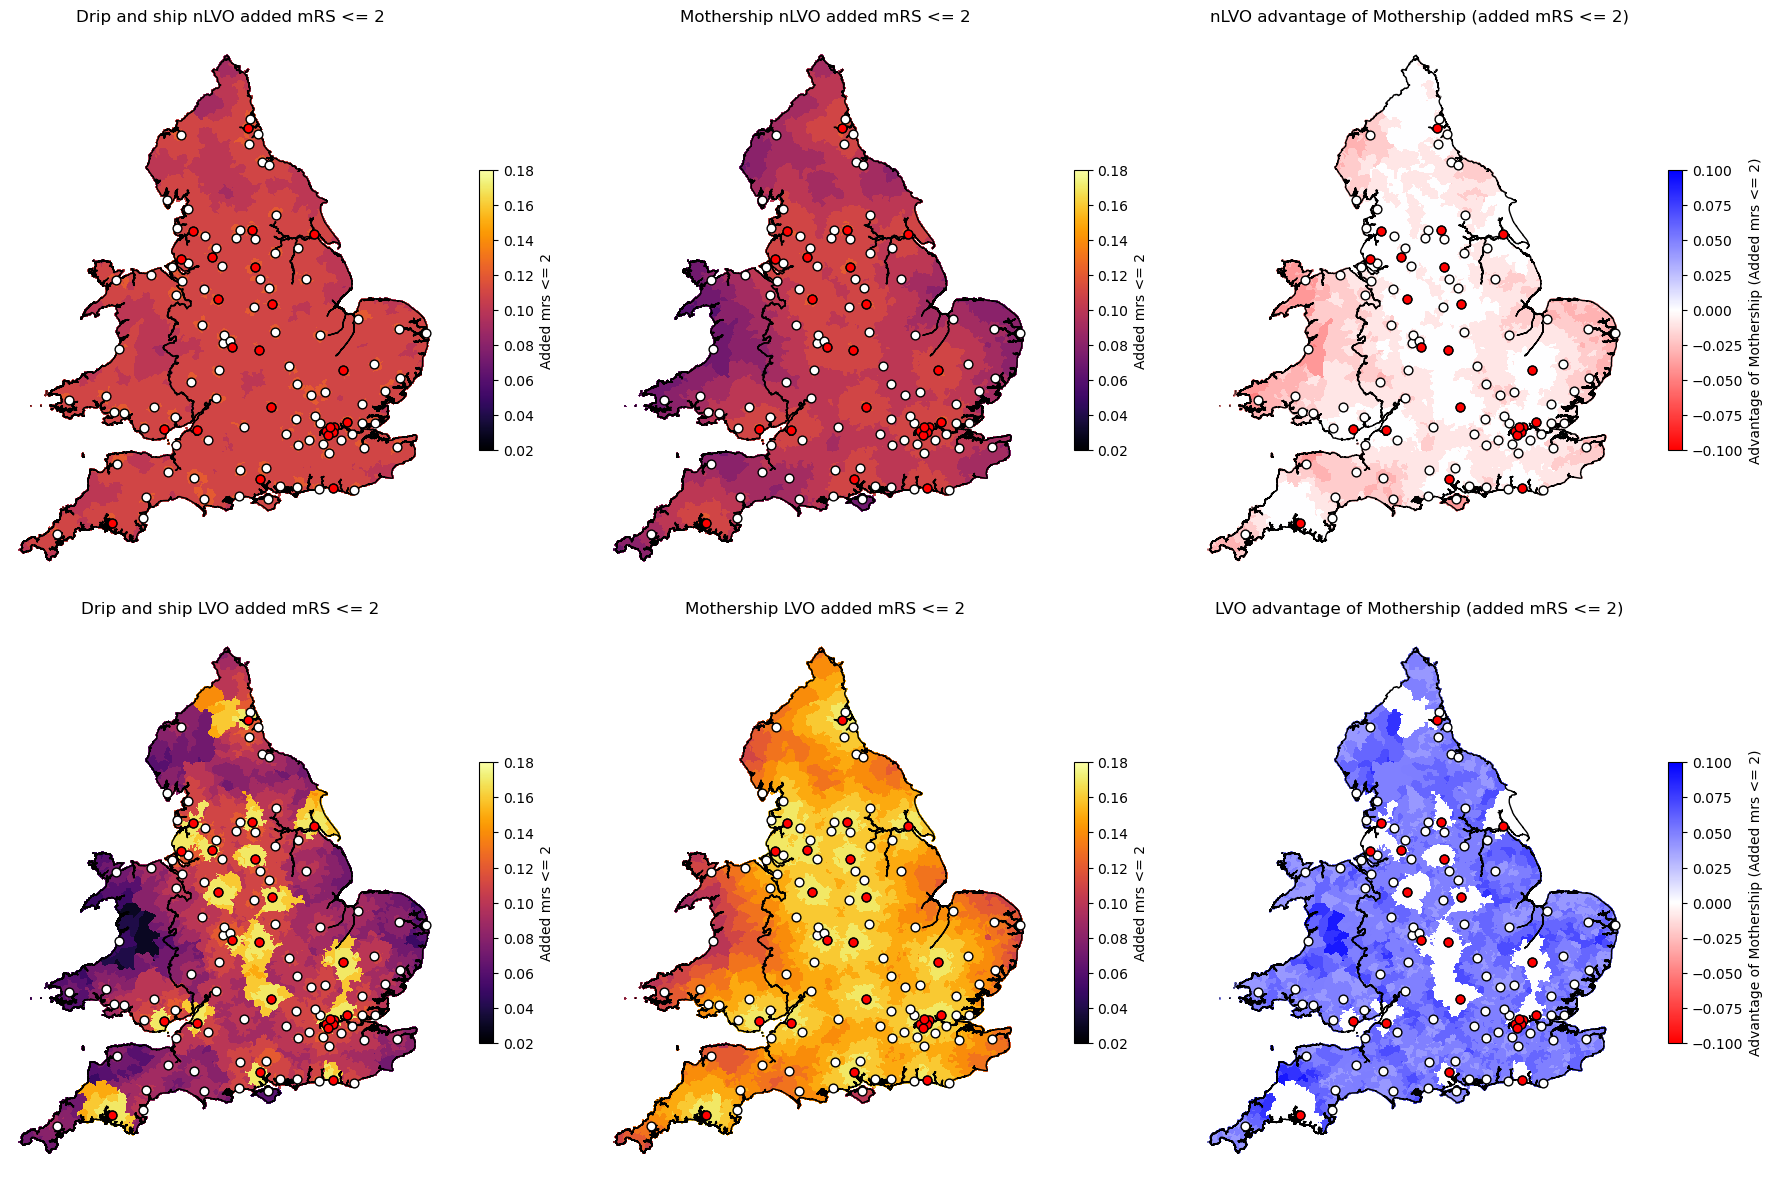

In [10]:
fig = plt.figure(figsize=(18,12))

################### Plot data values ###################

cols = [f'drip_ship_nlvo_ivt_{data_field}',
    f'mothership_nlvo_ivt_{data_field}',
    f'drip_ship_lvo_mt_{data_field}',
    f'mothership_lvo_mt_{data_field}']

titles = [f'Drip and ship nLVO {data_name}',
    f'Mothership nLVO {data_name}',
    f'Drip and ship LVO {data_name}',    
    f'Mothership LVO {data_name}']

# Indexes for subplots (to leave gaps on right for diff between Mothership and Drip and Ship)
indexes = [1, 2, 4, 5]

# Find maximum of data
vmin = np.min([lsoa_data_gdf[col].min() for col in cols])
vmax = np.max([lsoa_data_gdf[col].max() for col in cols])

for i in range(4):
    ax = fig.add_subplot(2, 3, indexes[i])

    # Plot data
    lsoa_data_gdf.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=cols[i], # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 vmin=vmin, # Manual scale min (remove to make automatic)
                 vmax=vmax, # Manual scale max (remove to make automatic)
                 cmap='inferno', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':f'{data_name.capitalize()}'},
                 # Set to display legend
                 legend=True)
    
    # Add country boarder
    outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
    
    # Add hospitals
    mask = hospitals_gdf['Use_IVT'] == '1'
    hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
    mask = hospitals_gdf['Use_MT'] == '1'
    hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')

    # Tighten map around mainland England and Wales
    ax.set_xlim(120000)

    ax.set_title(titles[i])
    ax.set_axis_off() # Turn of axis line and numbers

################### Plot differences between mothership and drip and ship ###################

cols = [f'nlvo_ivt_{data_field}_mothership_minus_dripship',
    f'lvo_mt_{data_field}_mothership_minus_dripship']

# Find absolute maximum of data extent
vmax = np.max((np.abs([lsoa_data_gdf[col].min() for col in cols]), 
               np.abs([lsoa_data_gdf[col].max() for col in cols])))
vmin = -vmax

titles = [f'nLVO advantage of Mothership ({data_name})',
          f'LVO advantage of Mothership ({data_name})']

# Indexes for subplots
indexes = [3, 6]

for i in range(2):
    ax = fig.add_subplot(2, 3, indexes[i])

    lsoa_data_gdf.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=cols[i], # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 vmin=vmin, # Manual scale min (remove to make automatic)
                 vmax=vmax, # Manual scale max (remove to make automatic)
                 cmap='bwr_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':f'Advantage of Mothership ({data_name.capitalize()})'},
                 # Set to display legend
                 legend=True)

    # Add country boarder
    outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
    
    # Add hospitals
    mask = hospitals_gdf['Use_IVT'] == '1'
    hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
    mask = hospitals_gdf['Use_MT'] == '1'
    hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')

    ax.set_title(titles[i])
    ax.set_axis_off() # Turn of axis line and numbers    

    # Tighten map around mainland England and Wales
    ax.set_xlim(120000)
    
plt.tight_layout(pad=1)
plt.savefig(f'./output/{data_field}_six_in_one.jpg', dpi=300, bbox_inches='tight')
plt.show()

Plot weighted benefit

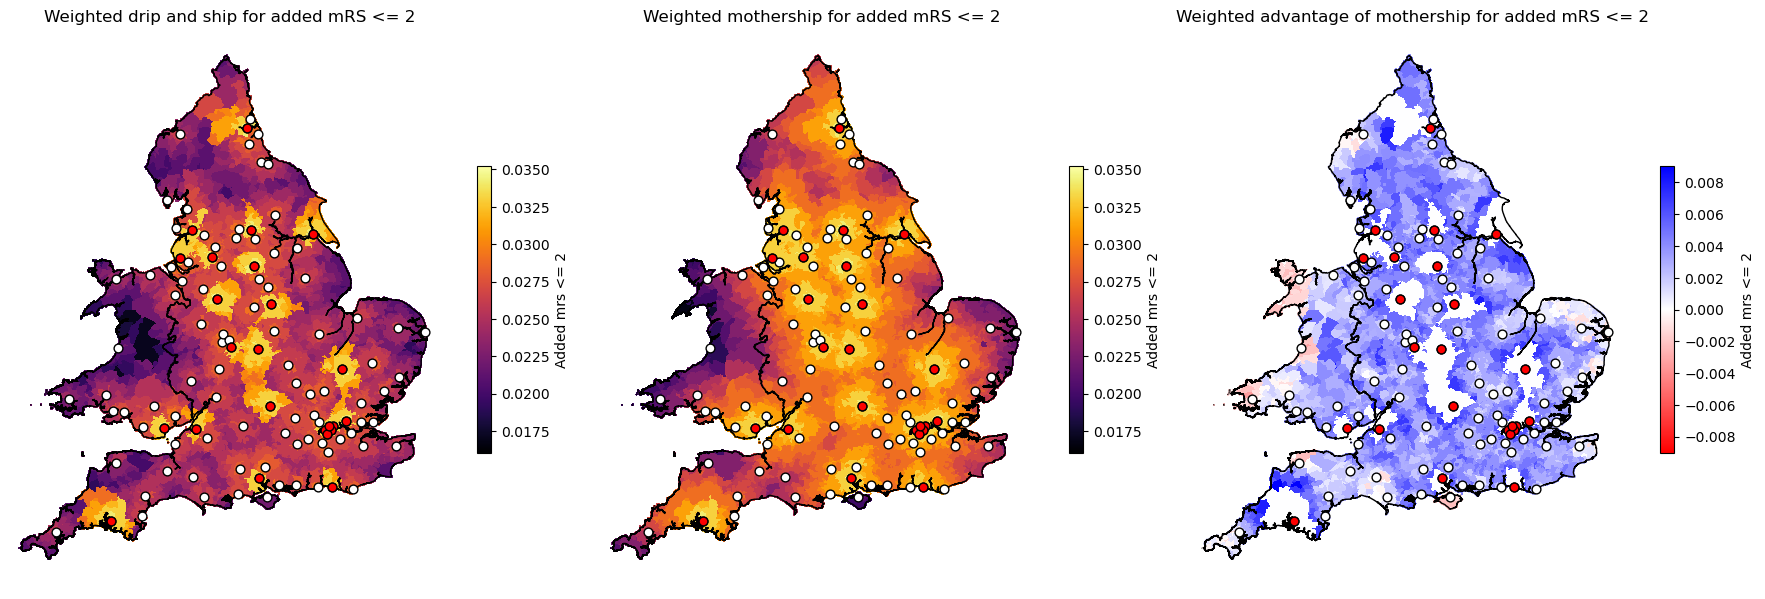

In [11]:
# Check weighted data exists
col = f'weighted_drip_ship_{data_field}'

if col not in lsoa_data_gdf.columns:
    print ('Required data does not exist')
else:
    lsoa_data_gdf[f'weighted_mothership_advantage_{data_field}'] = (
        lsoa_data_gdf[f'weighted_mothership_{data_field}'] - 
        lsoa_data_gdf[f'weighted_drip_ship_{data_field}'])

    fig = plt.figure(figsize=(18,6))

    # Set up columns to map
    cols = [
        f'weighted_drip_ship_{data_field}', 
        f'weighted_mothership_{data_field}',
        f'weighted_mothership_advantage_{data_field}']

    titles = [
        f'Weighted drip and ship for {data_name}',
        f'Weighted mothership for {data_name}',
        f'Weighted advantage of mothership for {data_name}']

    cmaps = ['inferno', 'inferno', 'bwr_r']

    # Find absolute maximum of data extent
    vmax = np.max([lsoa_data_gdf[col].max() for col in cols[0:2]])
    vmin = np.min([lsoa_data_gdf[col].min() for col in cols[0:2]])

    for i, col in enumerate(cols):
        ax = fig.add_subplot(1, 3, i+1)

        # Radjust vmin and max for advantage plot
        if i == 2:
            vmax = lsoa_data_gdf[col].max()
            vmin = lsoa_data_gdf[col].min()
            vmax = max(abs(vmax), abs(vmin))
            vmin = -vmax

        # Plot data
        lsoa_data_gdf.plot(ax=ax, # Set which axes to use for plot (only one here)
                    column=col, # Column to apply colour
                    antialiased=False, # Avoids artifact boundry lines
                    edgecolor='face', # Make LSOA boundry same colour as area
                    vmin=vmin, # Manual scale min (remove to make automatic)
                    vmax=vmax, # Manual scale max (remove to make automatic)
                    cmap=cmaps[i], # Colour map to use
                    # Adjust size of colourmap key, and add label
                    legend_kwds={'shrink':0.5, 'label':f'{data_name.capitalize()}'},
                    # Set to display legend
                    legend=True)
        
        # Add country boarder
        outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
        
        # Add hospitals
        mask = hospitals_gdf['Use_IVT'] == '1'
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
        mask = hospitals_gdf['Use_MT'] == '1'
        hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')

        # Tighten map around mainland England and Wales
        ax.set_xlim(120000)

        # Add title
        ax.set_title(titles[i])
        ax.set_axis_off() # Turn of axis line and numbers
    
    plt.tight_layout(pad=1)
    plt.savefig(f'./output/{data_field}_weighted_results.jpg', dpi=300, bbox_inches='tight')
    plt.show()